In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from InceptionTimeModel import *

--- Processing Intra-subject Training Data (with Validation Split) ---
Loading H5 data from data/Intra/train...
Applying downsampling (factor 5) to 4 loaded samples...
Applying chunking with chunk_length=1500, hop_length=750...
Chunking complete: 4 original samples expanded/processed into 296 chunks.
Splitting data into training and validation sets (validation_split=0.2, random_state=42)...
Training set size: 236, Validation set size: 60
Fitting new LabelEncoder on training data.
Fitted LabelEncoder. Classes: ['rest' 'task_motor' 'task_story_math' 'task_working_memory'] -> [0 1 2 3]
Loaded 236 samples/chunks into Training DataLoader from data/Intra/train.
LabelEncoder classes used for training: ['rest', 'task_motor', 'task_story_math', 'task_working_memory']
Loaded 60 samples/chunks into Validation DataLoader from data/Intra/train.
Effective params: (original_downsample_factor=5, chunk_length=1500, hop_length=750, normalize=True, validation_split=0.2).
Intra-subject training DataLoader

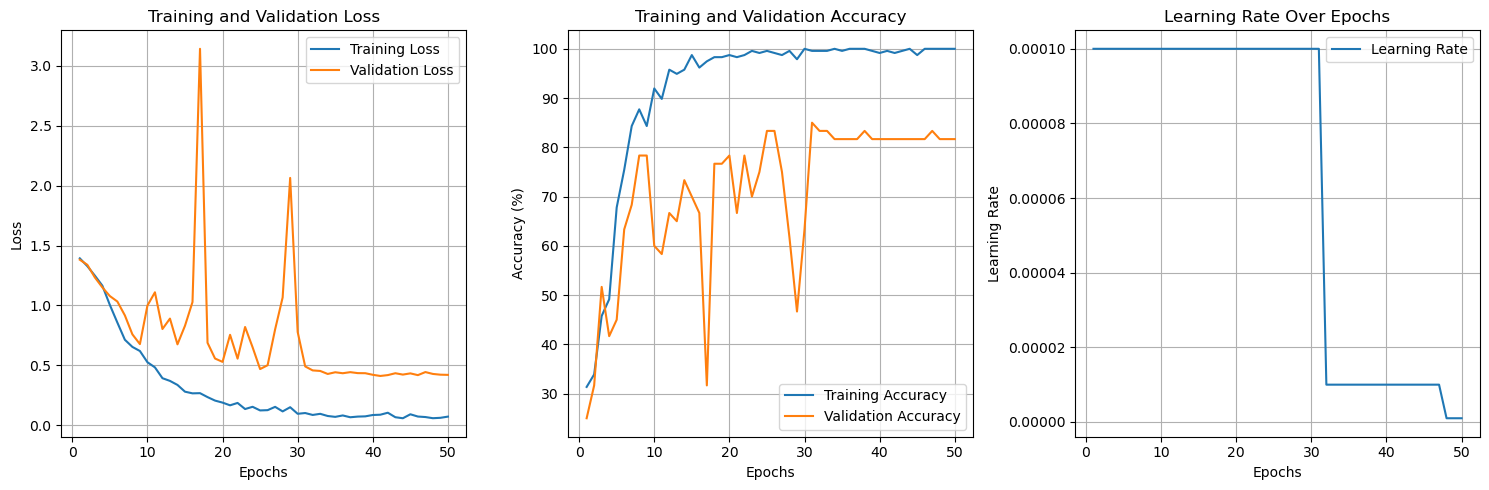


--- Evaluating on Test Set ---
Test Accuracy: 52.78%

Script finished.


In [7]:
from data_utils import prepare_pytorch_dataloader
from InceptionTimeModel import InceptionTime, train_model, plot_training_history
import torch
import numpy as np

if __name__ == '__main__':
    # Data paths
    intra_train_path = 'data/Intra/train'
    intra_test_path = 'data/Intra/test'
    
    # Data processing parameters
    DOWNSAMPLE_FACTOR = 5  # Consistent downsample factor for both train and test
    CHUNK_LENGTH = 1500
    HOP_LENGTH = 750
    NORMALIZE = True
    TRAIN_BATCH_SIZE = 16
    TEST_BATCH_SIZE = 64
    
    le_intra = None

    print("--- Processing Intra-subject Training Data (with Validation Split) ---")
    train_loader_intra, val_loader_intra, le_intra = prepare_pytorch_dataloader(
        intra_train_path, 
        batch_size=TRAIN_BATCH_SIZE, 
        shuffle_train=True, 
        num_workers=0, 
        downsample_factor=DOWNSAMPLE_FACTOR, 
        chunk_length=CHUNK_LENGTH, 
        hop_length=HOP_LENGTH, 
        normalize=NORMALIZE,
        validation_split=0.2, 
        random_state=42
    )
    
    if train_loader_intra and le_intra: 
        print(f"Intra-subject training DataLoader created. Label mapping: {dict(zip(le_intra.classes_, le_intra.transform(le_intra.classes_)))}")
        if val_loader_intra:
            print("Intra-subject validation DataLoader created.")
        else:
            print("Intra-subject validation DataLoader was NOT created (check split or data).")
    elif not train_loader_intra:
        print("Failed to create Intra-subject training DataLoader. Exiting.")
        exit()

    print("\n--- Processing Intra-subject Test Data ---")
    test_loader_intra = None
    if le_intra: 
        test_loader_intra, _, _ = prepare_pytorch_dataloader(
            intra_test_path, 
            batch_size=TEST_BATCH_SIZE, 
            shuffle_train=False, 
            label_encoder=le_intra, 
            num_workers=0, 
            downsample_factor=DOWNSAMPLE_FACTOR,  # Using same downsample factor as training
            chunk_length=CHUNK_LENGTH,  # Using same chunk length as training
            hop_length=HOP_LENGTH,  # Using same hop length as training
            normalize=NORMALIZE,  # Using same normalization as training
            validation_split=None
        )
        if test_loader_intra:
            print("Intra-subject test DataLoader created.")
        else:
            print("Failed to create Intra-subject test DataLoader (possibly due to label issues or no data).")
    else:
        print("Skipping Intra-subject test data processing as training label encoder is missing.")

    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Set device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    # Determine number of classes from the label encoder
    if le_intra:
        num_classes = len(le_intra.classes_)
        print(f"Number of classes determined from label encoder: {num_classes}")
    else:
        print("Error: Label encoder not available. Cannot determine number of classes. Exiting.")
        exit()

    model = InceptionTime(
        in_channels=248,
        n_classes=num_classes, 
        n_filters=16,
        n_blocks=2,   
        bottleneck_channels=16
    ).to(device)

    print("\nModel Architecture:")
    print(model)

    print("\n--- Training Model ---")
    if train_loader_intra and val_loader_intra:
        model, history = train_model(
            model=model,
            train_loader=train_loader_intra, 
            val_loader=val_loader_intra,
            epochs=50,
            lr=0.0001,
            patience=10,
            lr_patience=5,
            lr_factor=0.1
        )
        
        print("\n--- Plotting Training History ---")
        plot_training_history(history)
    else:
        print("Skipping model training as training or validation data loader is missing.")
        exit()

    print("\n--- Evaluating on Test Set ---")
    if test_loader_intra:
        model.eval()
        total_test_samples = 0
        correct_test_predictions = 0

        with torch.no_grad():
            for test_X_batch, test_y_batch in test_loader_intra: 
                test_X_batch = test_X_batch.to(device)
                test_y_batch = test_y_batch.to(device)
                outputs = model(test_X_batch)
                _, predicted = torch.max(outputs, 1)
                total_test_samples += test_y_batch.size(0)
                correct_test_predictions += (predicted == test_y_batch).sum().item()

        if total_test_samples > 0:
            accuracy = 100 * correct_test_predictions / total_test_samples
            print(f'Test Accuracy: {accuracy:.2f}%')
        else:
            print("No samples in the test set to evaluate.")
    else:
        print("Skipping test set evaluation as test data loader is missing.")

    print("\nScript finished.")